In [1]:
import os
import pickle
import argparse
import matplotlib
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [2]:
data_dir = "data"
save_dir = "visualization"
lan = 'en'

This functions consider the grammatical class (noun, adjective, verb, etc.) associated to each word and plots  the first selected amount of words (`words_per_class`) for each class. They compute just one set of coordinates for all the words (according to the dimensionality reduction method chosen) and plot the subset of selected words on such coordinates.

In [3]:
def PlotEmbeddingsWithClasses(class2idx, classes, X, words_per_class, save_dir, lan, method='pca', ngrams=False):
    n_classes = len(class2idx.keys())
    cm = plt.get_cmap('terrain')
    colors = [cm(1.*i/n_classes) for i in range(n_classes)]
    
    plt.figure(figsize=(20, 20))
    for i in range(n_classes):
        subset = [k for k,c in enumerate(classes) if c == i]
        scatter = plt.scatter(X[subset[:words_per_class],0], X[subset[:words_per_class],1],
                              label=list(class2idx.keys())[i], color = colors[i],
                              s=20)
    plt.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    plt.ylim((np.min(X[:, 1]), np.max(X[:, 1])))
    plt.legend()
    if ngrams:
        plt.title(f'Embeddings with ngrams - language = {lan} - method = {method} - words per class = {words_per_class}')
        plt.savefig(os.path.join(save_dir, lan, f'Embedding_C_{lan}_{method}_wpc{words_per_class}_ngrams.png'),
                    dpi=200, bbox_inches = 'tight')
    else:
        plt.title(f'Embeddings without ngrams - language = {lan} - method = {method} - words per class = {words_per_class}')
        plt.savefig(os.path.join(save_dir, lan, f'Embedding_C_{lan}_{method}_wpc{words_per_class}.png'),
                    dpi=200, bbox_inches = 'tight')
        
def PlotEmbeddingsWithWords(classes, X, words, words_per_class, save_dir, lan, method='pca', ngrams=False):
    n_classes = len(set(classes))
    cm = plt.get_cmap('terrain')
    colors = [cm(1.*i/n_classes) for i in range(n_classes)]
    
    plt.figure(figsize=(20, 20))
    for i in range(n_classes):
        subset = [k for k,c in enumerate(classes) if c == i][:words_per_class]
        for wi in subset:
            plt.text(X[wi,0], X[wi,1], words[wi], bbox=dict(facecolor=colors[i], alpha=0.1))
    plt.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    plt.ylim((np.min(X[:, 1]), np.max(X[:, 1])))               
    if ngrams:
        plt.title(f'Embeddings with ngrams - language = {lan} - method = {method} - words per class = {words_per_class}')
        plt.savefig(os.path.join(save_dir, lan, f'Embedding_W_{lan}_{method}_wpc{words_per_class}_ngrams.png'),
                    dpi=200, bbox_inches = 'tight')
    else:
        plt.title(f'Embeddings without ngrams - language = {lan} - method = {method} - words per class = {words_per_class}')
        plt.savefig(os.path.join(save_dir, lan, f'Embedding_W_{lan}_{method}_wpc{words_per_class}.png'),
                    dpi=200, bbox_inches = 'tight')


def VisualizeEmbeddingsWithClasses(data_dir, save_dir, lan, words_per_class = 100, ngrams = False,
                                   pca=False, tsne=False, both=False,
                                    c = False, w = False):
    
    word2class = pickle.load(open(os.path.join(data_dir, lan, 'word2class.dat'), 'rb'))
    word2class["|"] = '_'
    
    class2idx = {word_class : i for i, word_class in enumerate(sorted(set(word2class.values())))}
    
    if ngrams:
        idx2vec = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec_ngrams.dat'), 'rb'))
    else:
        idx2vec = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec.dat'), 'rb'))
    
    word2idx = pickle.load(open(os.path.join(data_dir, lan, 'word2idx.dat'), 'rb'))
                           
    word_counts = pickle.load(open(os.path.join(data_dir, lan, 'wc.dat'), 'rb'))
    
    # Words sorted in order of frequency in the training data set
    words = sorted(word_counts, key=word_counts.get, reverse=True)  
    embs = [idx2vec[word2idx[word]] for word in words]
    classes = [class2idx[word2class[word]] for word in words]
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    if not os.path.isdir(os.path.join(save_dir,lan)):
        os.mkdir(os.path.join(save_dir,lan))
    if pca:
        try :
            if ngrams: X = pickle.load(open(os.path.join(save_dir, lan, 'X_pca_ngrams.dat'),'rb'))
            else: X = pickle.load(open(os.path.join(save_dir, lan, 'X_pca.dat'),'rb'))
        except OSError:
            X = PCA(n_components = 2).fit_transform(embs)
            if ngrams: pickle.dump(X,open(os.path.join(save_dir, lan, 'X_pca_ngrams.dat'),'wb'))
            else: pickle.dump(X,open(os.path.join(save_dir, lan, 'X_pca.dat'),'wb'))
        
        if c: PlotEmbeddingsWithClasses(class2idx, classes, X, words_per_class, save_dir, lan ,'pca', ngrams)
        elif w: PlotEmbeddingsWithWords(classes, X, words, words_per_class, save_dir, lan, 'pca', ngrams)
    
    if tsne:
        try :
            if ngrams: X = pickle.load(open(os.path.join(save_dir, lan, 'X_tsne_ngrams.dat'),'rb'))
            else: X = pickle.load(open(os.path.join(save_dir, lan, 'X_tsne.dat'),'rb'))
        except OSError:
            X = TSNE(n_components = 2).fit_transform(embs)
            if ngrams: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_tsne_ngrams.dat'),'wb'))
            else: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_tsne.dat'),'wb'))
        
        if c: PlotEmbeddingsWithClasses(class2idx, classes, X, words_per_class, save_dir, lan, 'tsne', ngrams)
        elif w: PlotEmbeddingsWithWords(classes, X, words, words_per_class, save_dir, lan, 'tsne', ngrams)
    
    if both:
        try :
            if ngrams: X = pickle.load(open(os.path.join(save_dir, lan, 'X_pca_tsne_ngrams.dat'),'rb')) 
            else: X = pickle.load(open(os.path.join(save_dir, lan, 'X_pca_tsne.dat'),'rb'))
        except OSError:
            X = PCA(n_components = 30).fit_transform(embs)
            X = TSNE(n_components = 2).fit_transform(X)
            if ngrams: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_pca_tsne_ngrams.dat'),'wb'))
            else: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_pca_tsne.dat'),'wb'))
        if c: PlotEmbeddingsWithClasses(class2idx, classes, X, words_per_class, save_dir, lan, 'pca_tsne', ngrams) 
        elif w: PlotEmbeddingsWithWords(classes, X, words, words_per_class, save_dir, lan, 'pca_tsne', ngrams)
      
                           

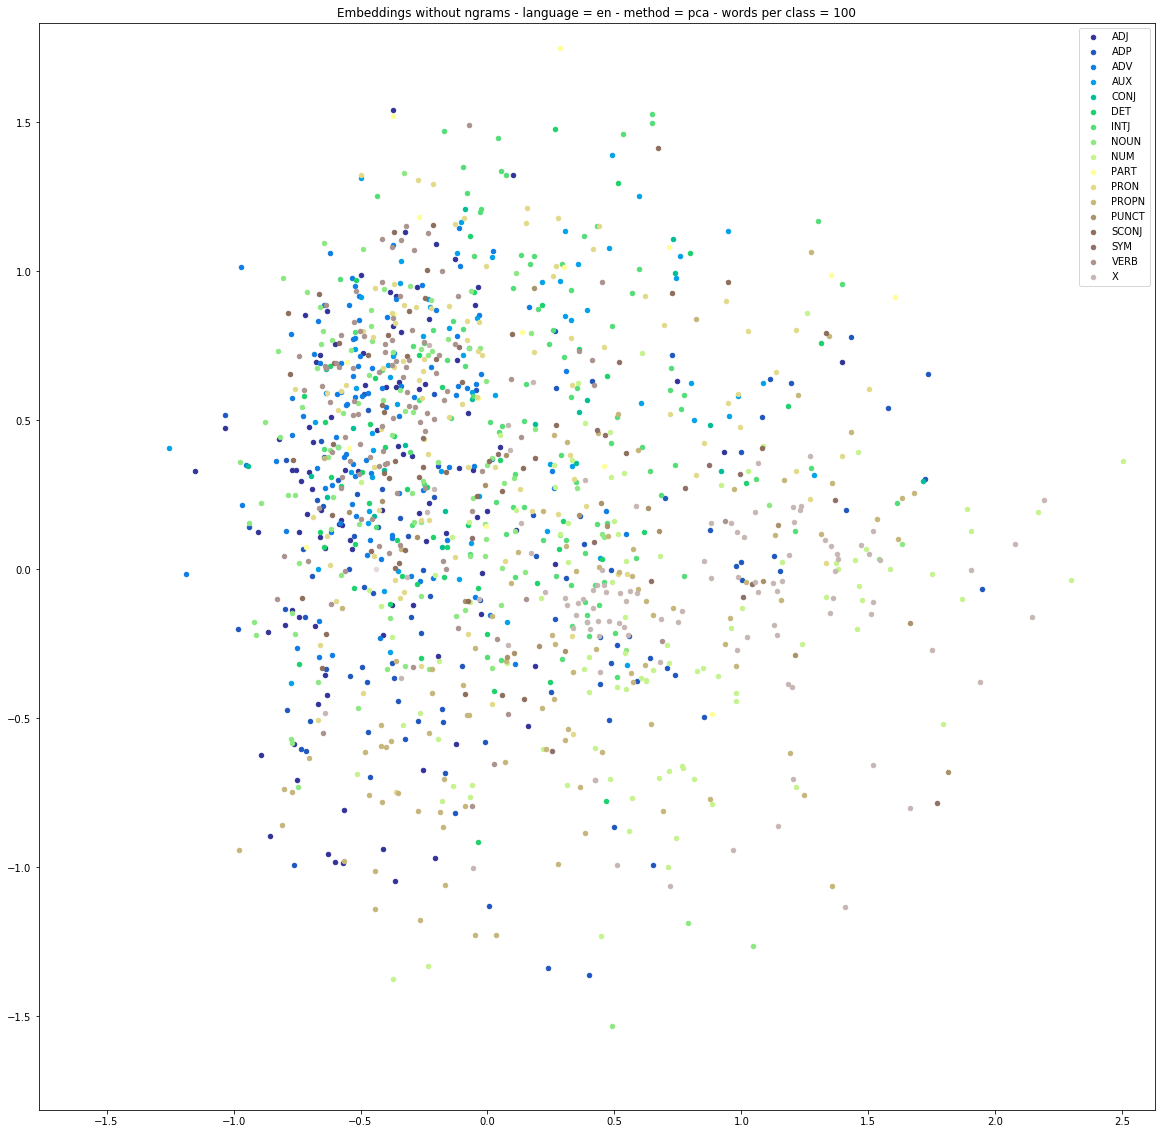

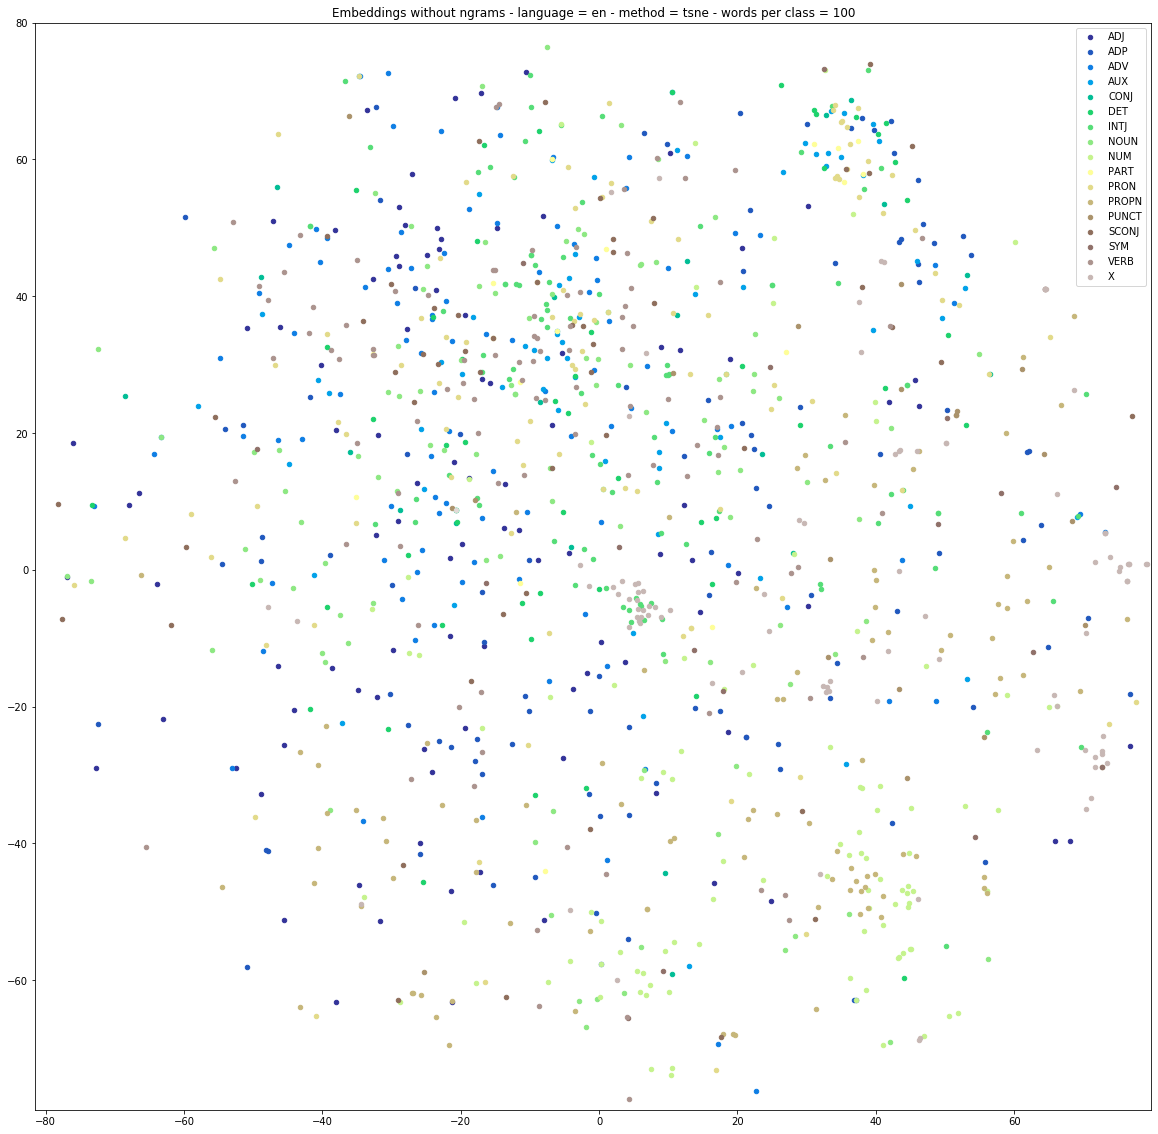

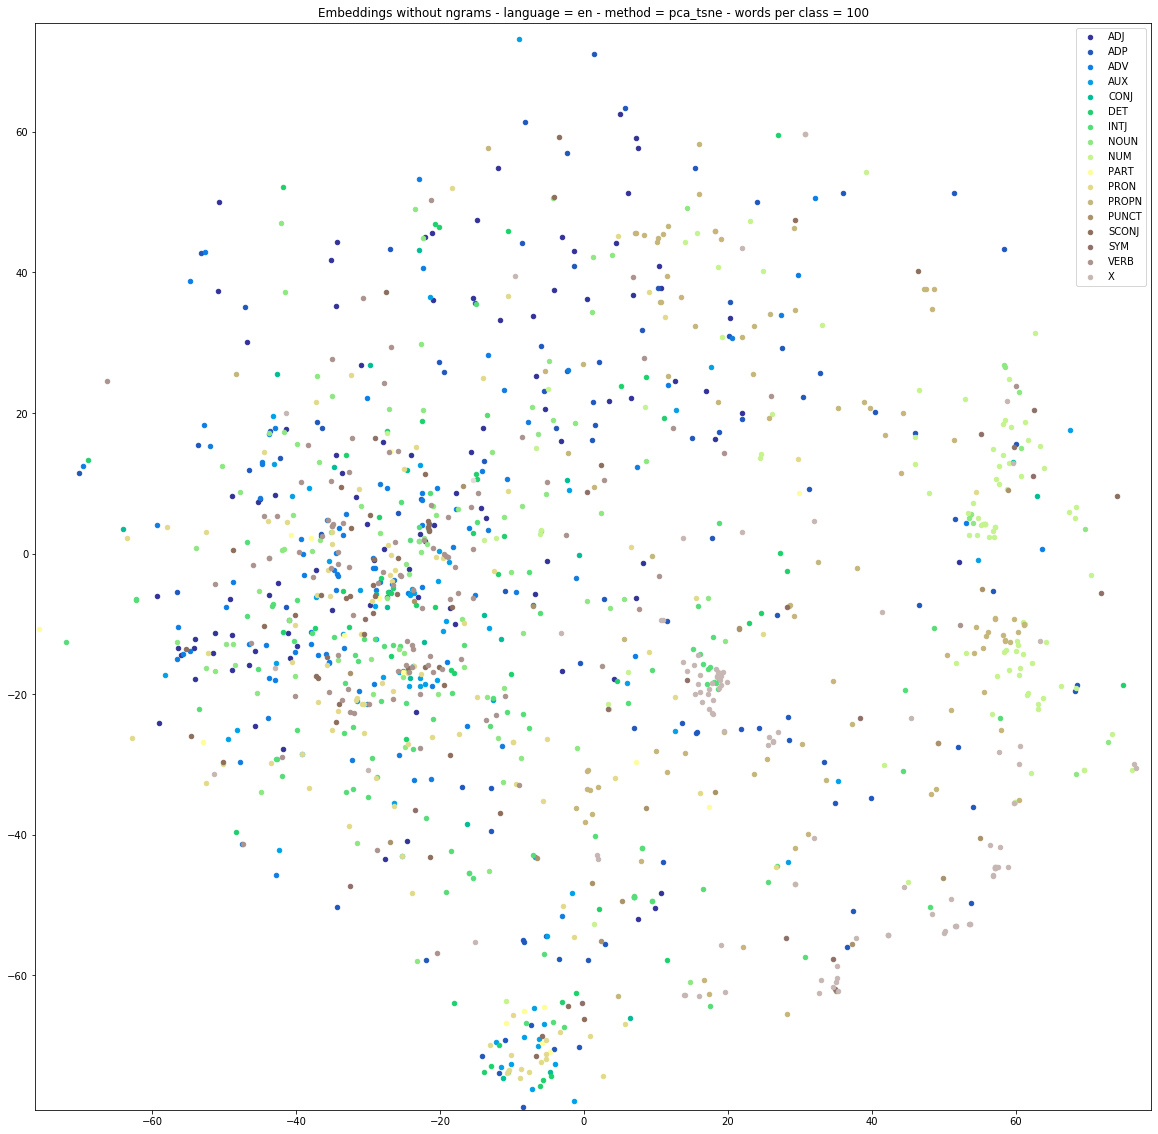

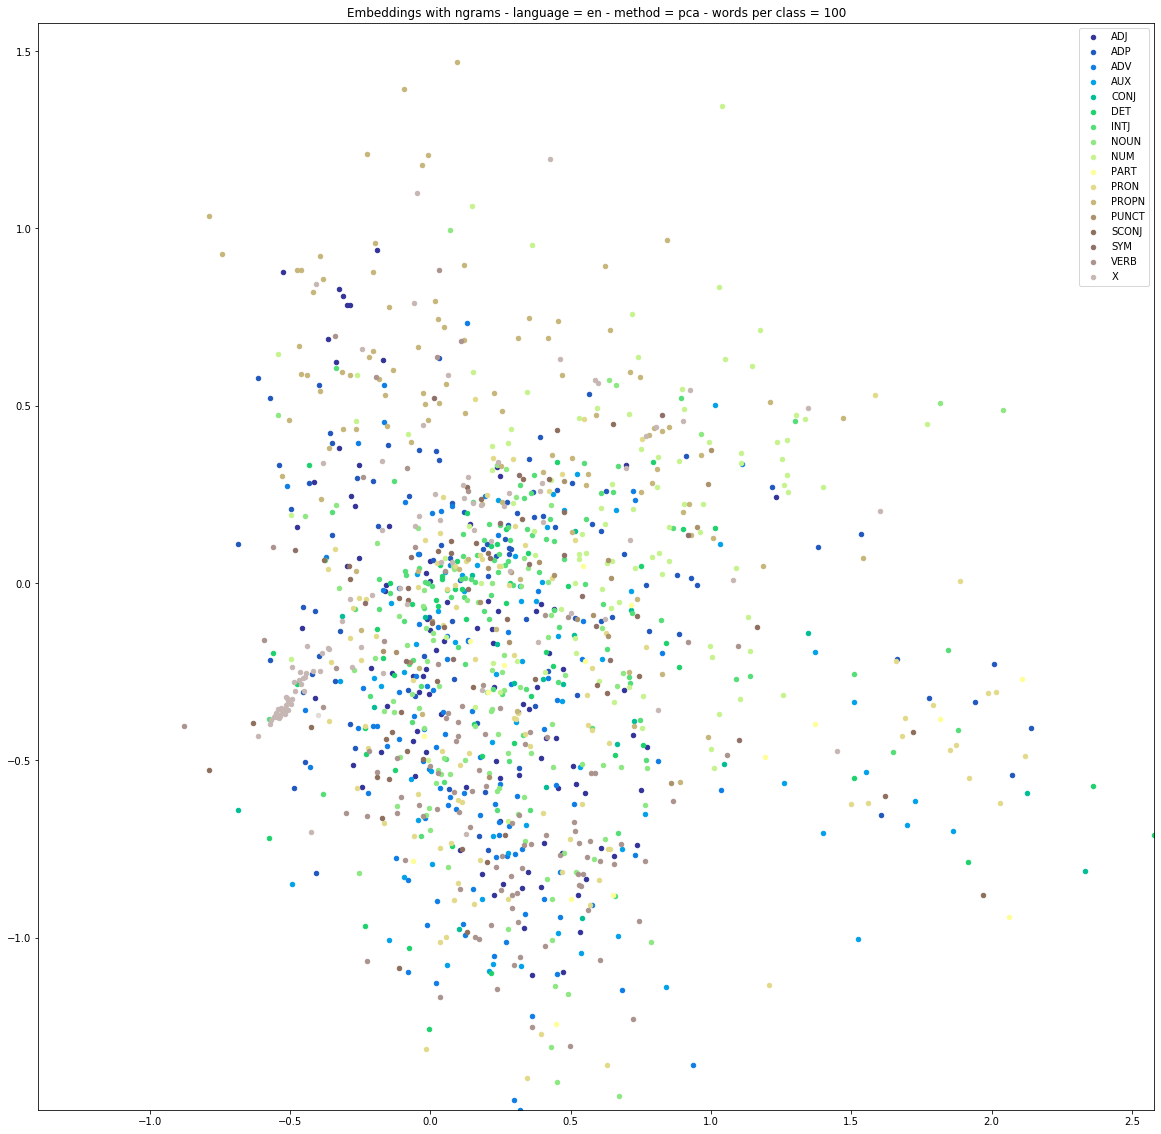

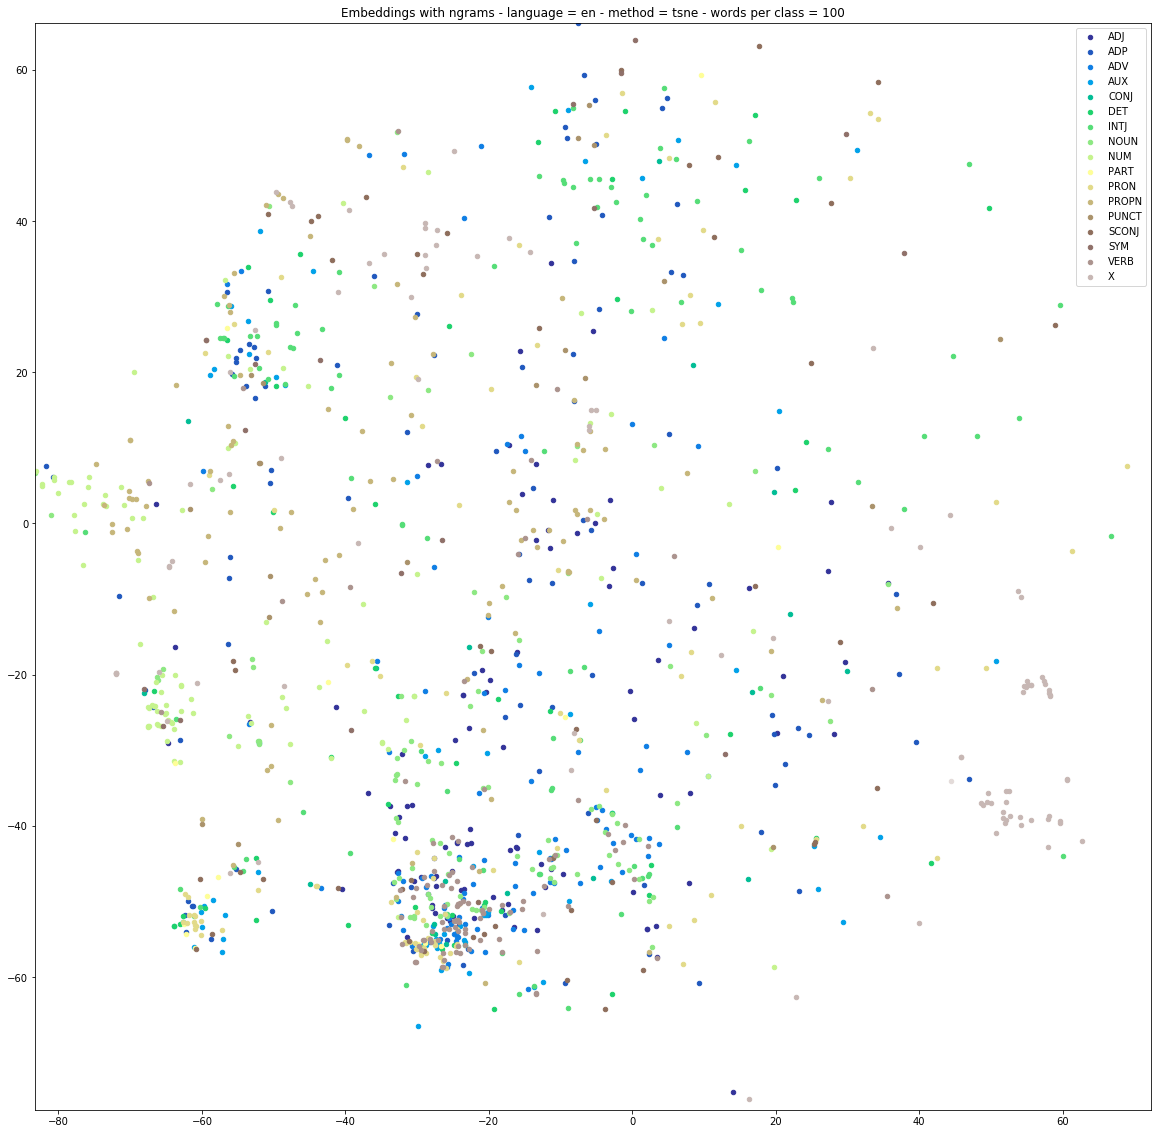

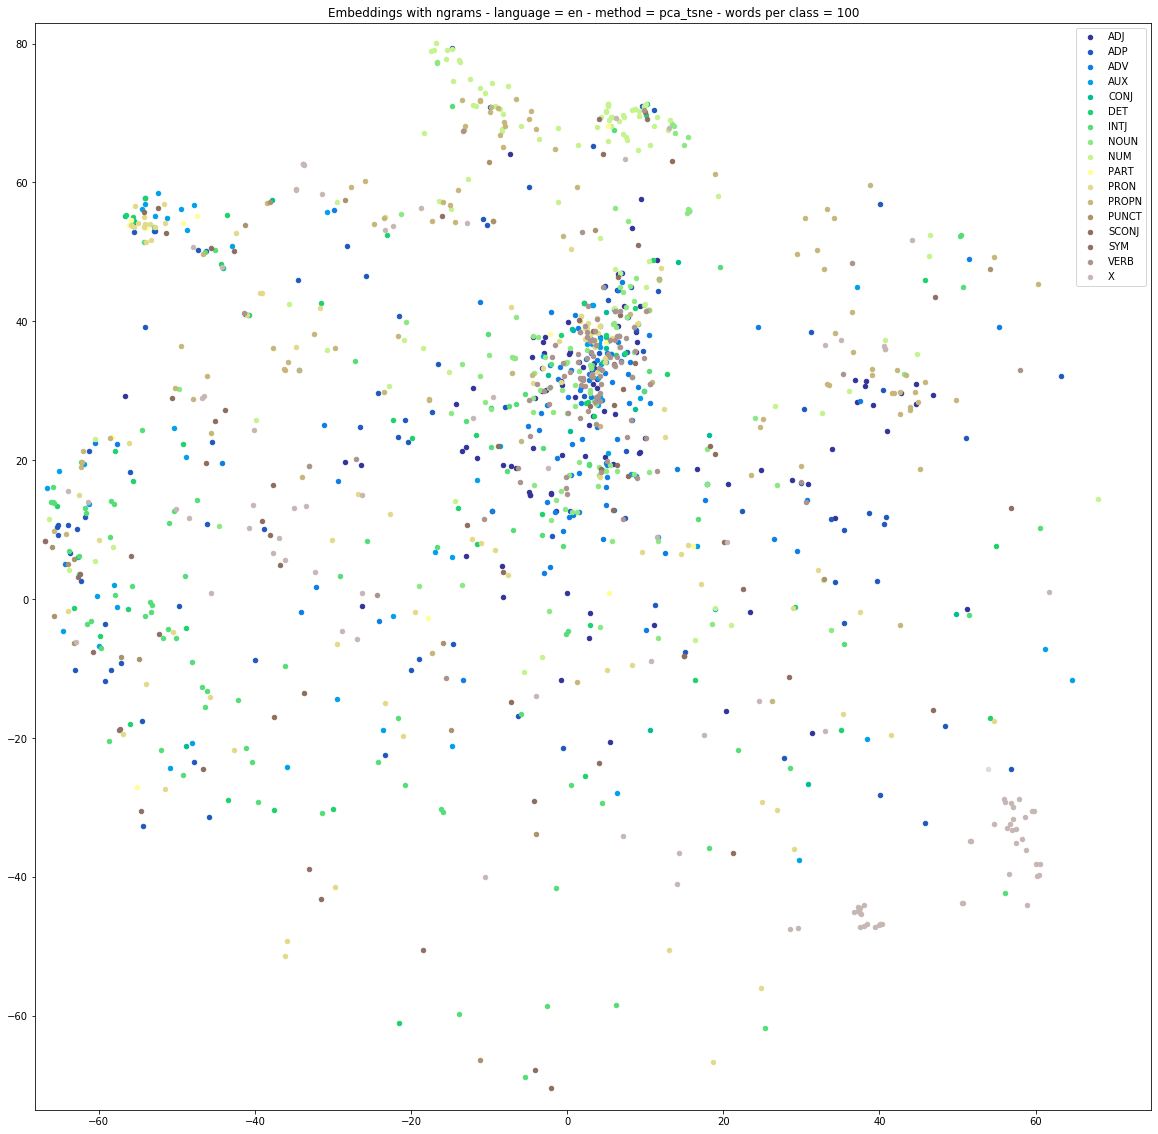

In [4]:
# Just points 
VisualizeEmbeddingsWithClasses(data_dir, save_dir, lan, words_per_class = 100, 
                               ngrams = False,
                               pca=True, tsne=True, both=True,
                               c = True)
VisualizeEmbeddingsWithClasses(data_dir, save_dir, lan, words_per_class = 100,
                               ngrams = True,
                               pca=True, tsne=True, both=True,
                               c = True)

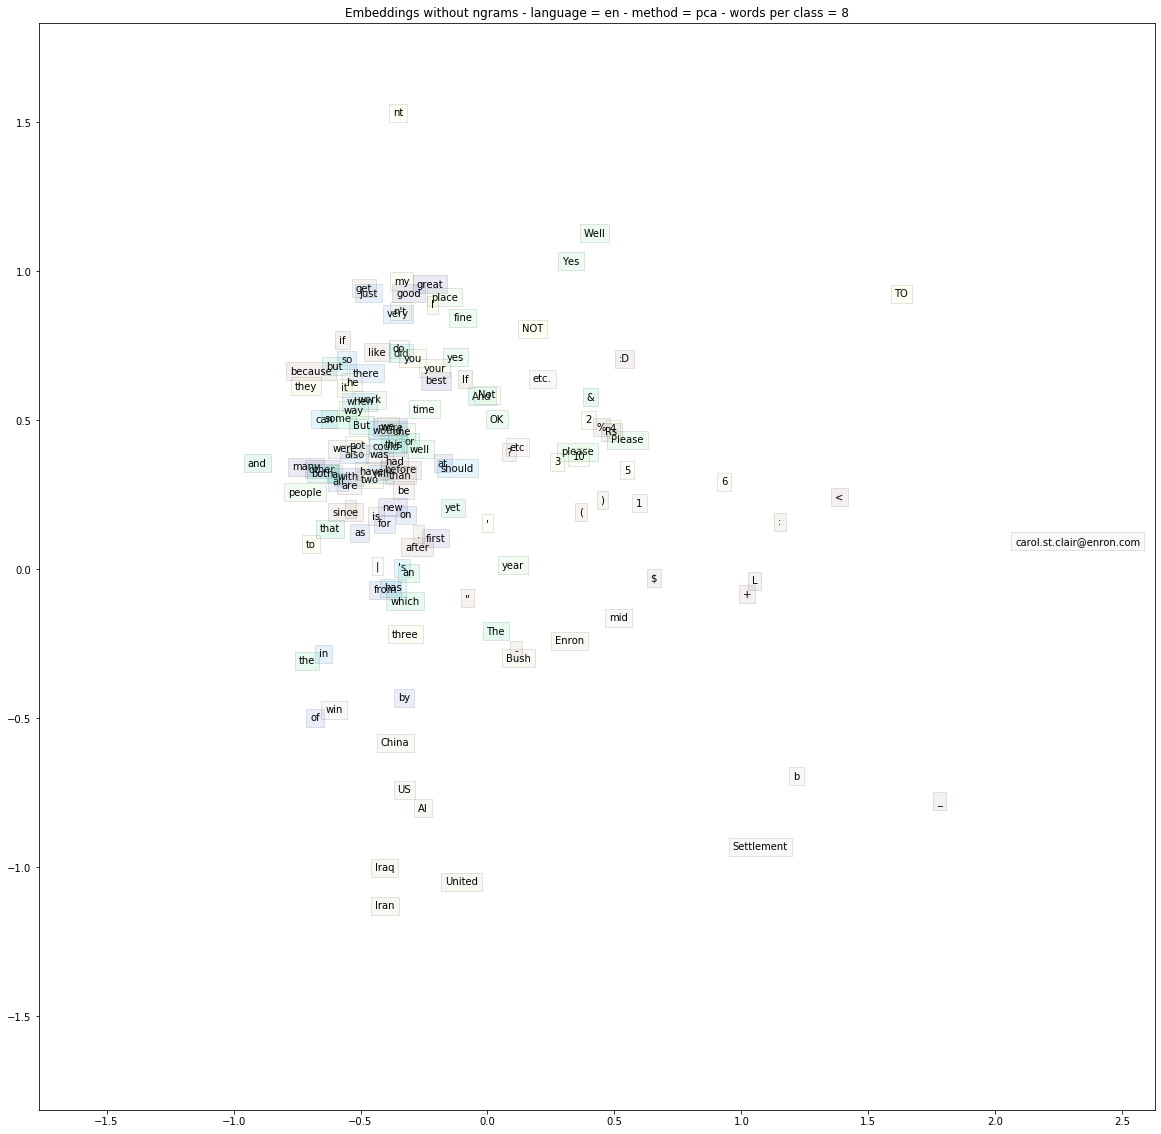

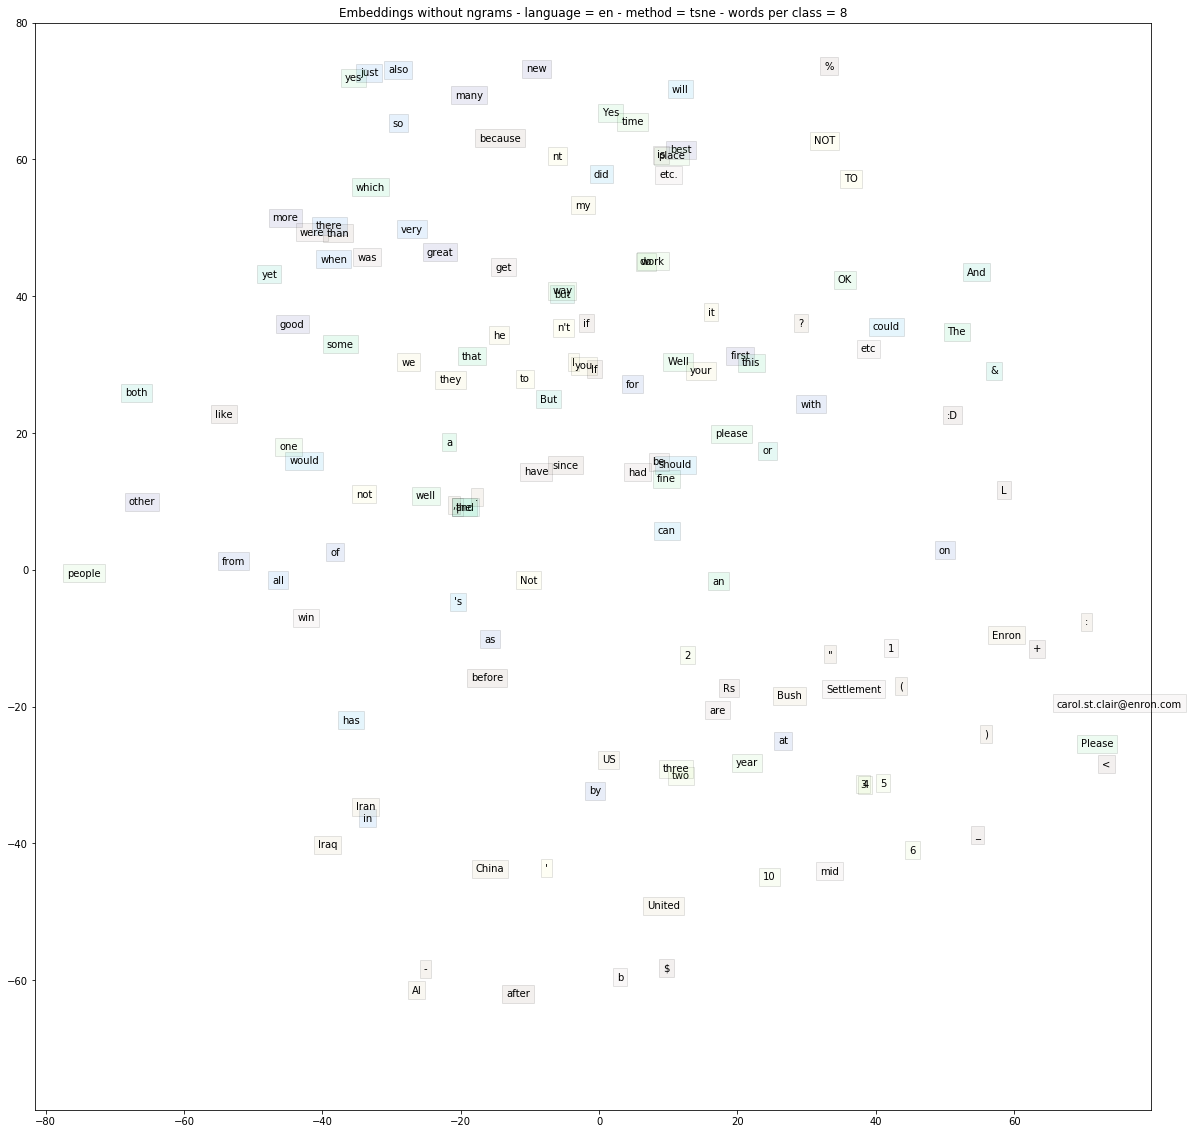

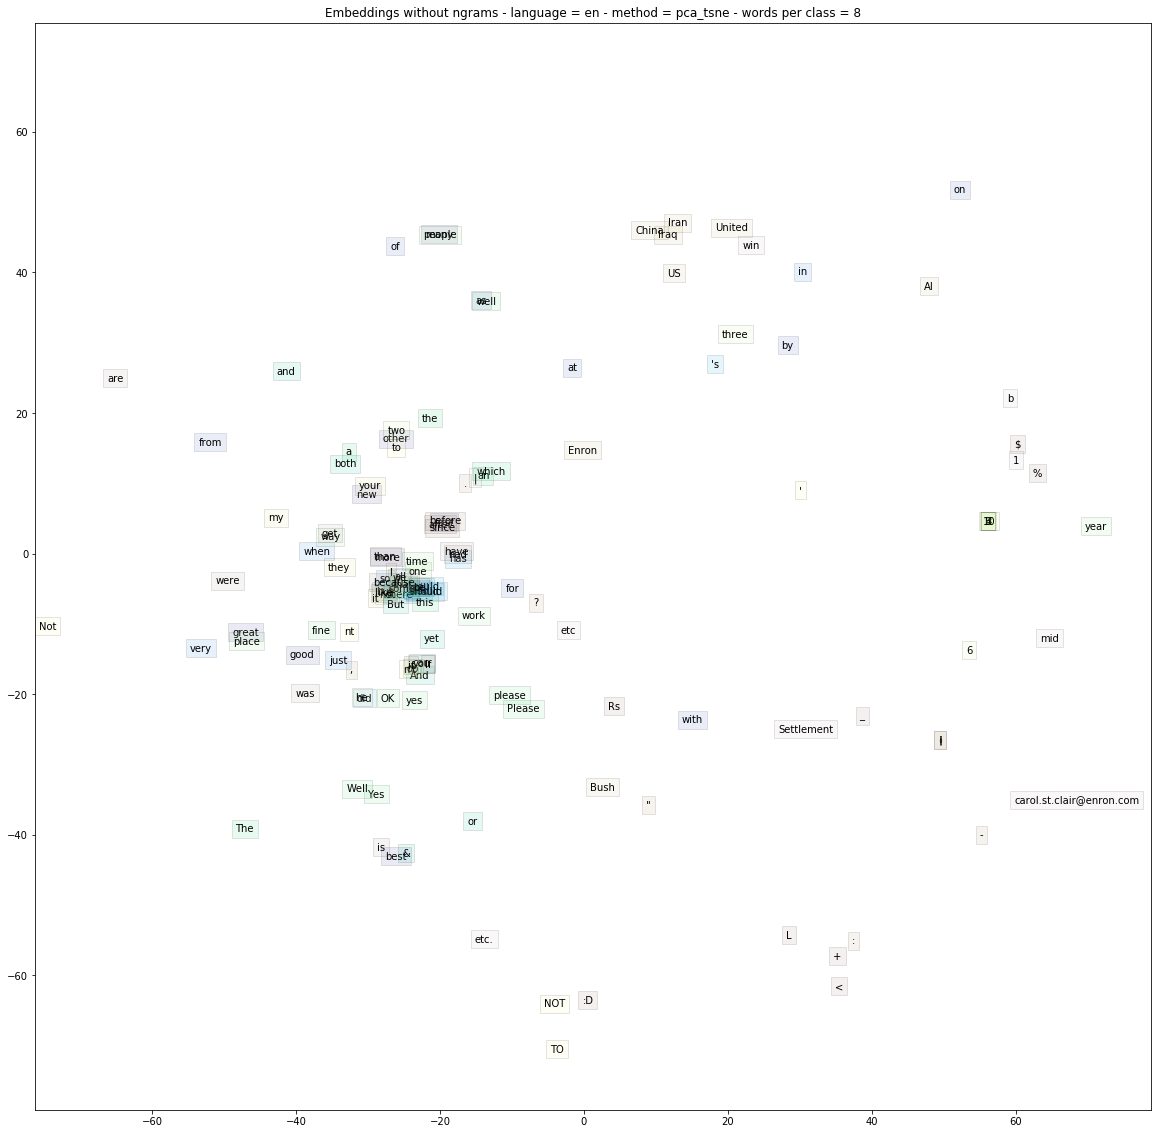

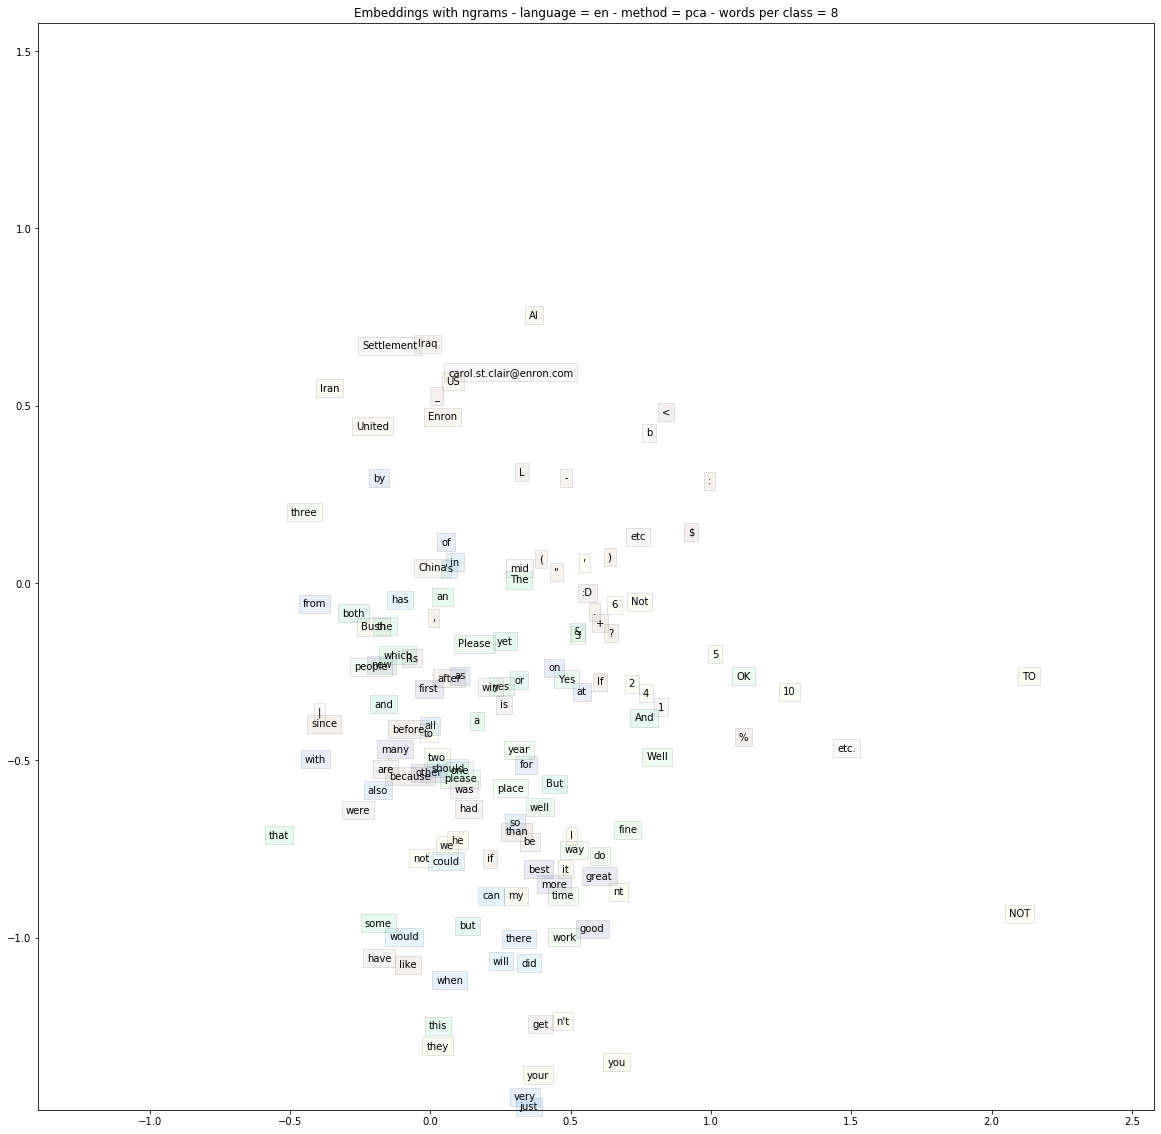

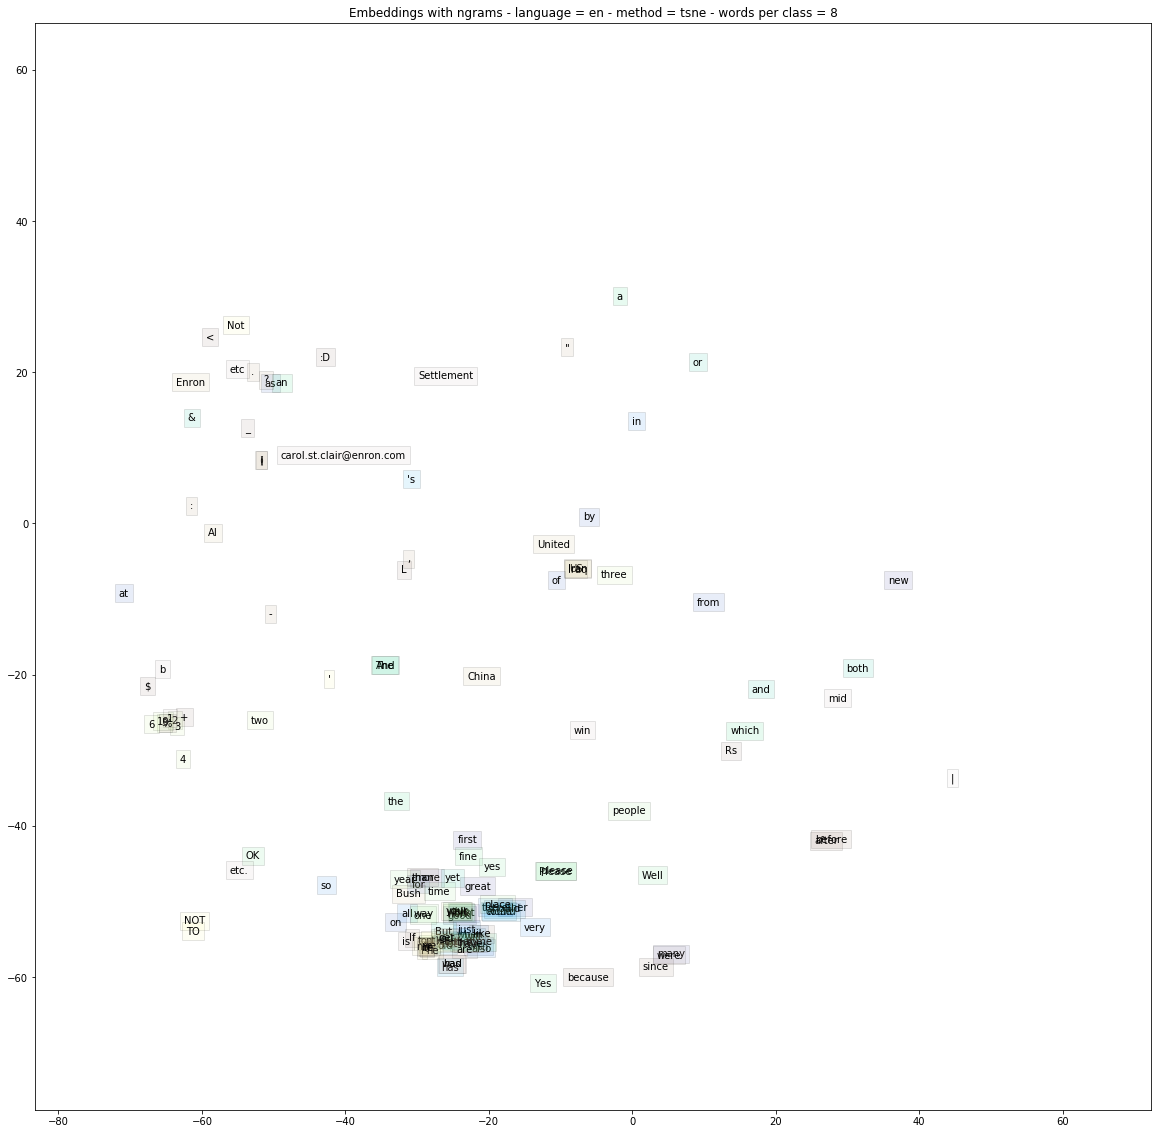

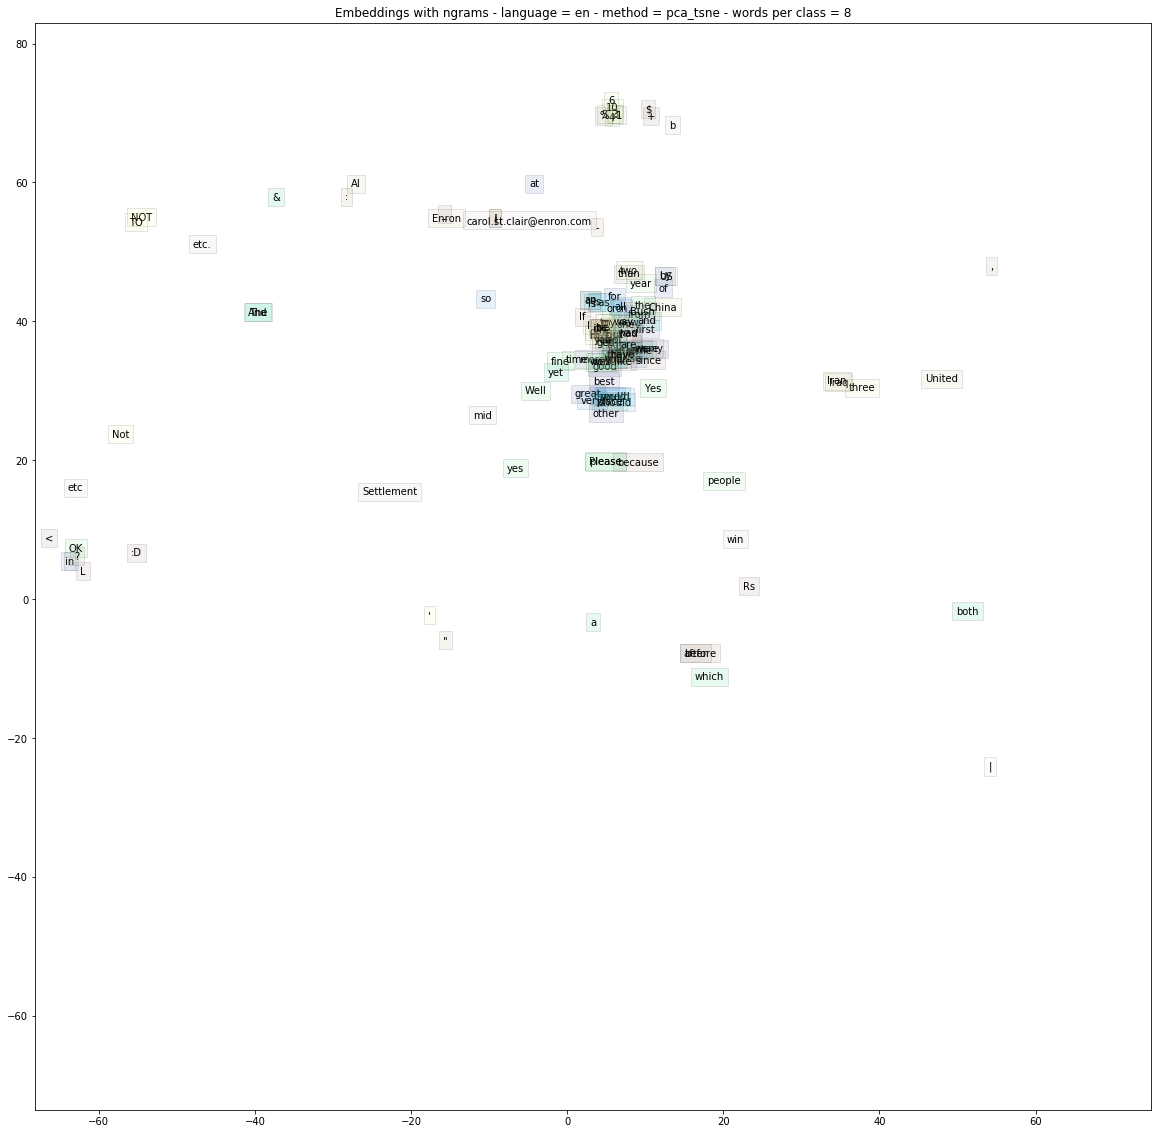

In [5]:
# Words
VisualizeEmbeddingsWithClasses(data_dir, save_dir, lan, words_per_class = 8, ngrams = False,
                               pca=True, tsne=True, both=True,
                               w = True)
VisualizeEmbeddingsWithClasses(data_dir, save_dir, lan, words_per_class = 8, ngrams = True,
                               pca=True, tsne=True, both=True,
                               w = True)

This functions just consider the selected words (ordered by frequency in the training data set). They recompute every time the set of coordinates only for the subset of words selected (according to the dimensionality reduction method chosen) and plot them.

In [6]:
def PlotChosenWords(X, words, save_dir, lan, method='pca', ngrams=False):
    
    plt.figure(figsize=(20, 20))
    for i in range(len(words)):
        plt.text(X[i,0], X[i,1], words[i], bbox=dict(facecolor='blue', alpha=0.1))
    plt.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    plt.ylim((np.min(X[:, 1]), np.max(X[:, 1])))               
    if ngrams:
        plt.title(f"Selected words' embeddings with ngrams - language = {lan} - method = {method}")
        plt.savefig(os.path.join(save_dir, lan, f'Selected_embedding_{lan}_{method}_ngrams.png'),
                    dpi=200, bbox_inches = 'tight')
    else:
        plt.title(f"Selected words' embeddings without ngrams - language = {lan} - method = {method}")
        plt.savefig(os.path.join(save_dir, lan, f'Selected_embedding_{lan}_{method}.png'),
                    dpi=200, bbox_inches = 'tight')

def VisualizeChosenWords(data_dir, save_dir, lan, list_of_idx, ngrams = False,
                        pca=False, tsne=False, both=False):
    word_counts = pickle.load(open(os.path.join(data_dir, lan, 'wc.dat'), 'rb'))
    words = np.array(sorted(word_counts, key=word_counts.get, reverse=True))[list_of_idx]
    
    word2idx = pickle.load(open(os.path.join(data_dir, lan, 'word2idx.dat'), 'rb'))
    
    if ngrams:
        idx2vec = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec_ngrams.dat'), 'rb'))
    else:
        idx2vec = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec.dat'), 'rb'))
    
    embs = [idx2vec[word2idx[word]] for word in words]
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    if not os.path.isdir(os.path.join(save_dir,lan)):
        os.mkdir(os.path.join(save_dir,lan))
    
    if pca:
        X = PCA(n_components = 2).fit_transform(embs)
        if ngrams: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_pca_ngrams_selected.dat'),'wb'))
        else: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_pca_selected.dat'),'wb'))
        PlotChosenWords(X, words, save_dir, lan, 'pca', ngrams)
        
    if tsne:
        X = TSNE(n_components = 2).fit_transform(embs)
        if ngrams: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_tsne_ngrams_selected.dat'),'wb'))
        else: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_tsne_selected.dat'),'wb'))
        PlotChosenWords(X, words, save_dir, lan, 'tsne', ngrams)
    
    if both:
        X = PCA(n_components = 30).fit_transform(embs)
        X = TSNE(n_components = 2).fit_transform(X)
        if ngrams: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_pca_tsne_ngrams_selected.dat'),'wb'))
        else: pickle.dump(X, open(os.path.join(save_dir, lan, 'X_pca_tsne_selected.dat'),'wb'))
        PlotChosenWords(X, words, save_dir, lan, 'pca_tsne', ngrams)

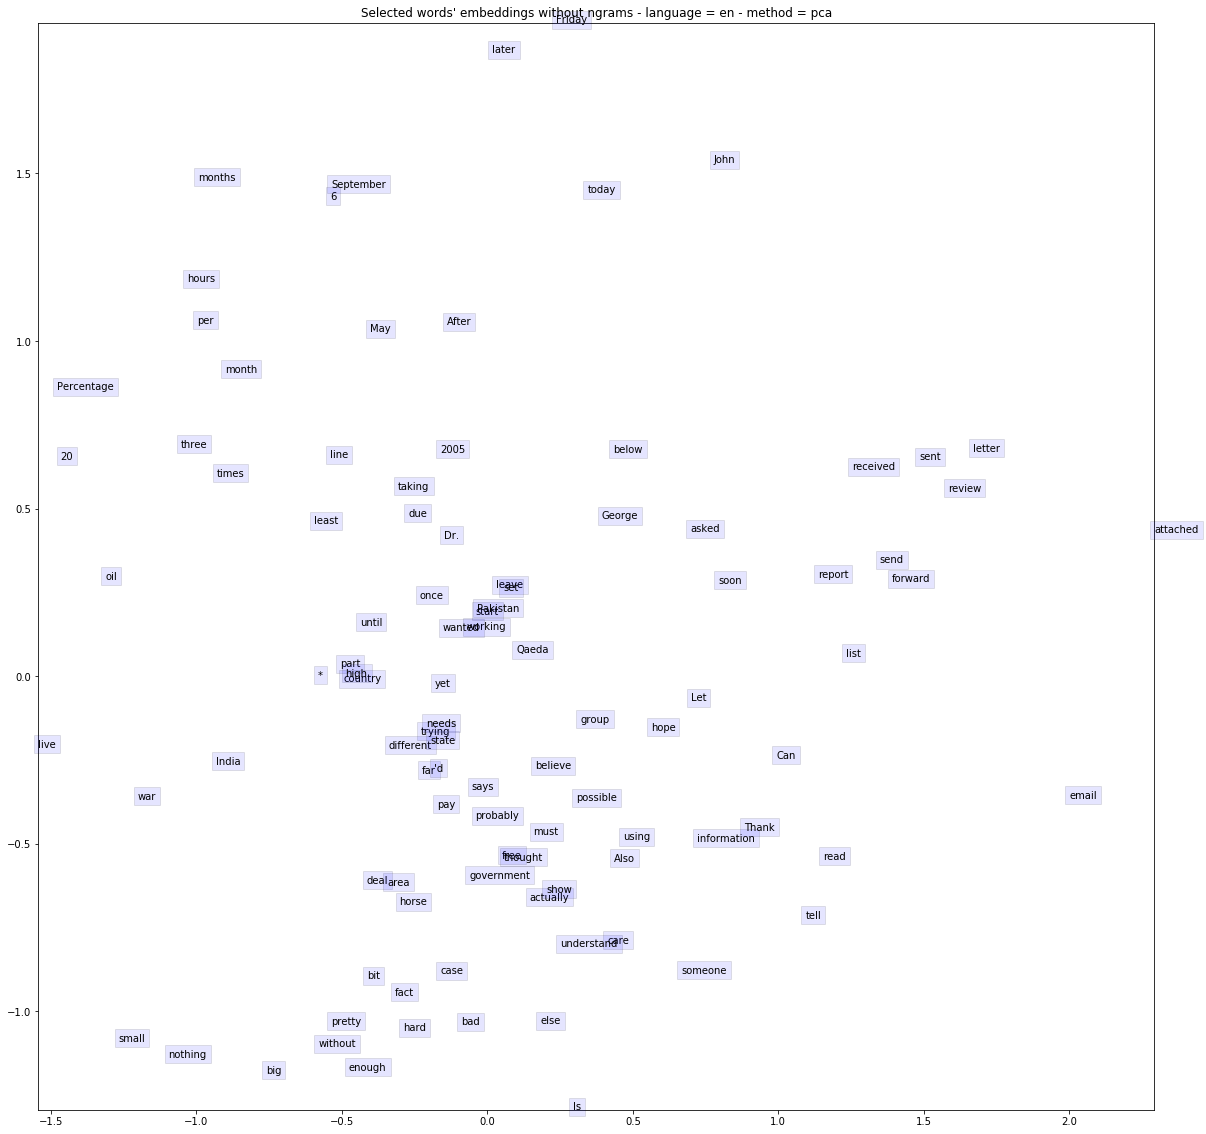

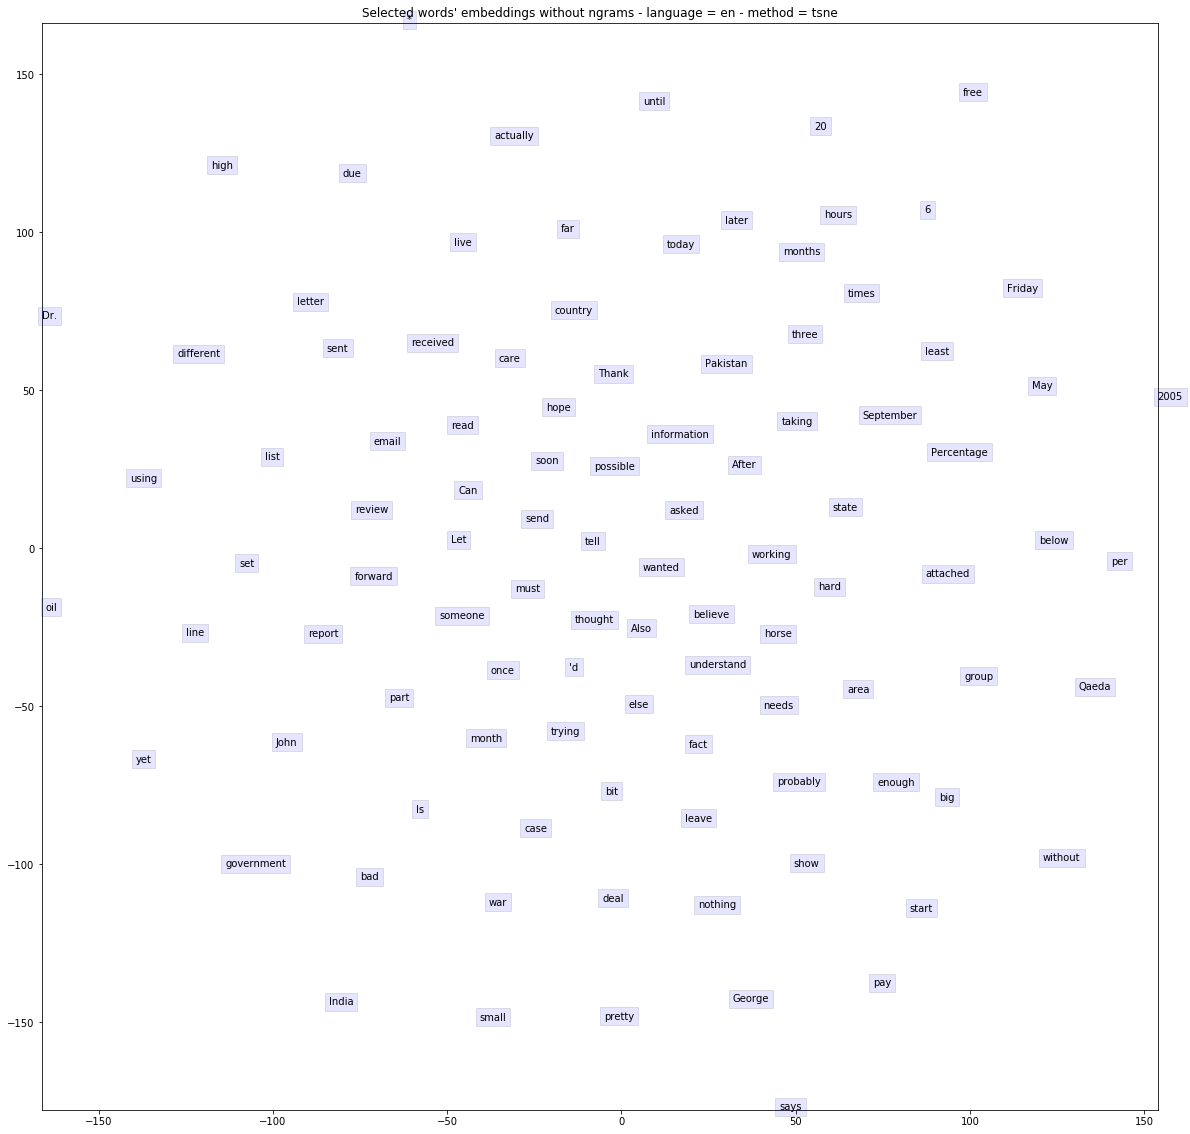

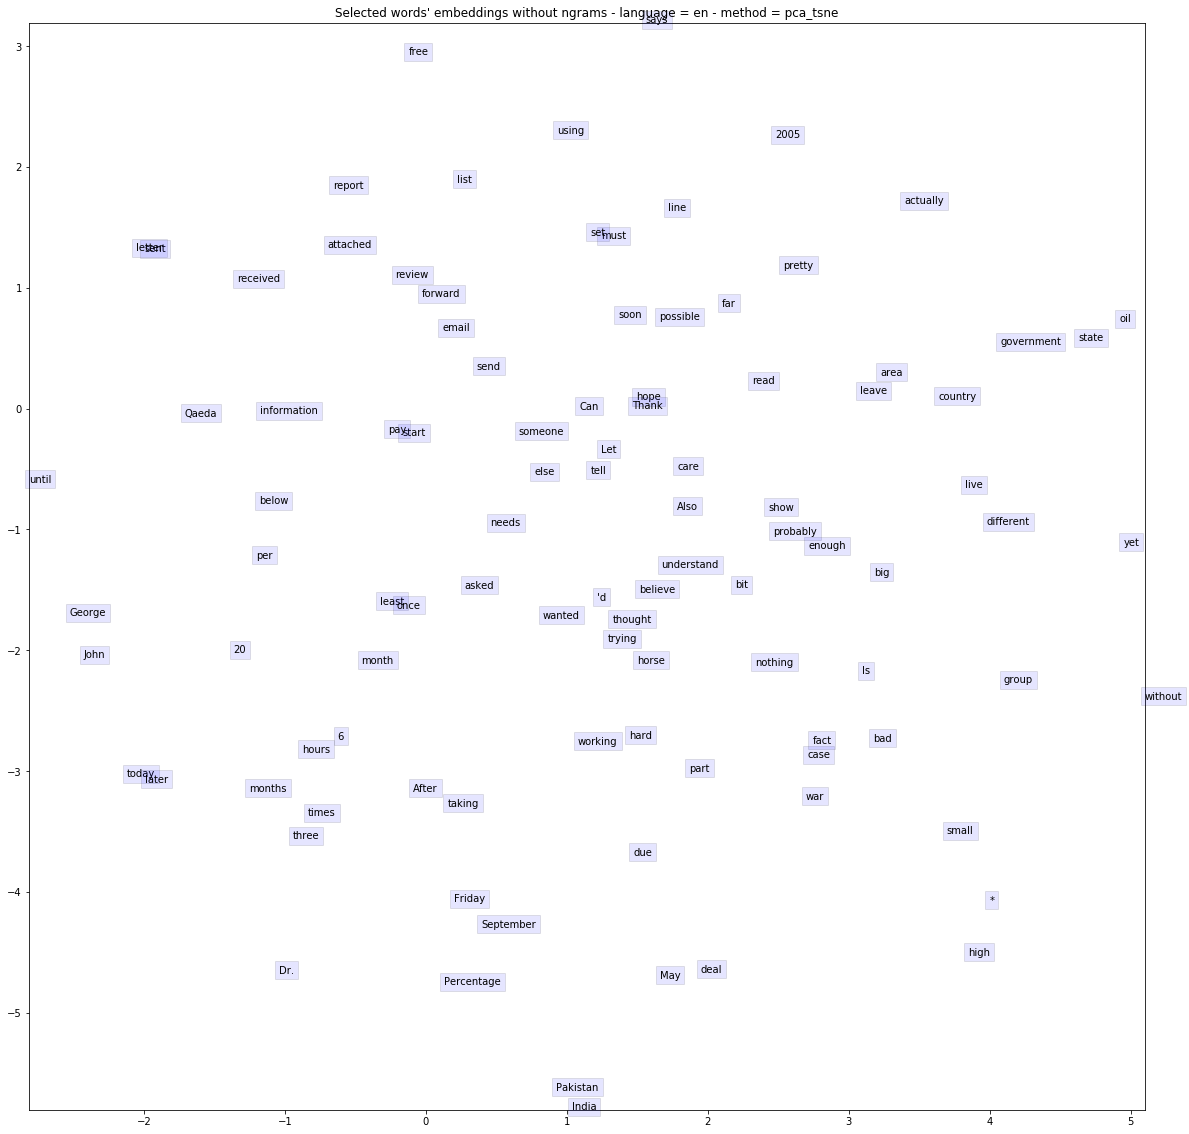

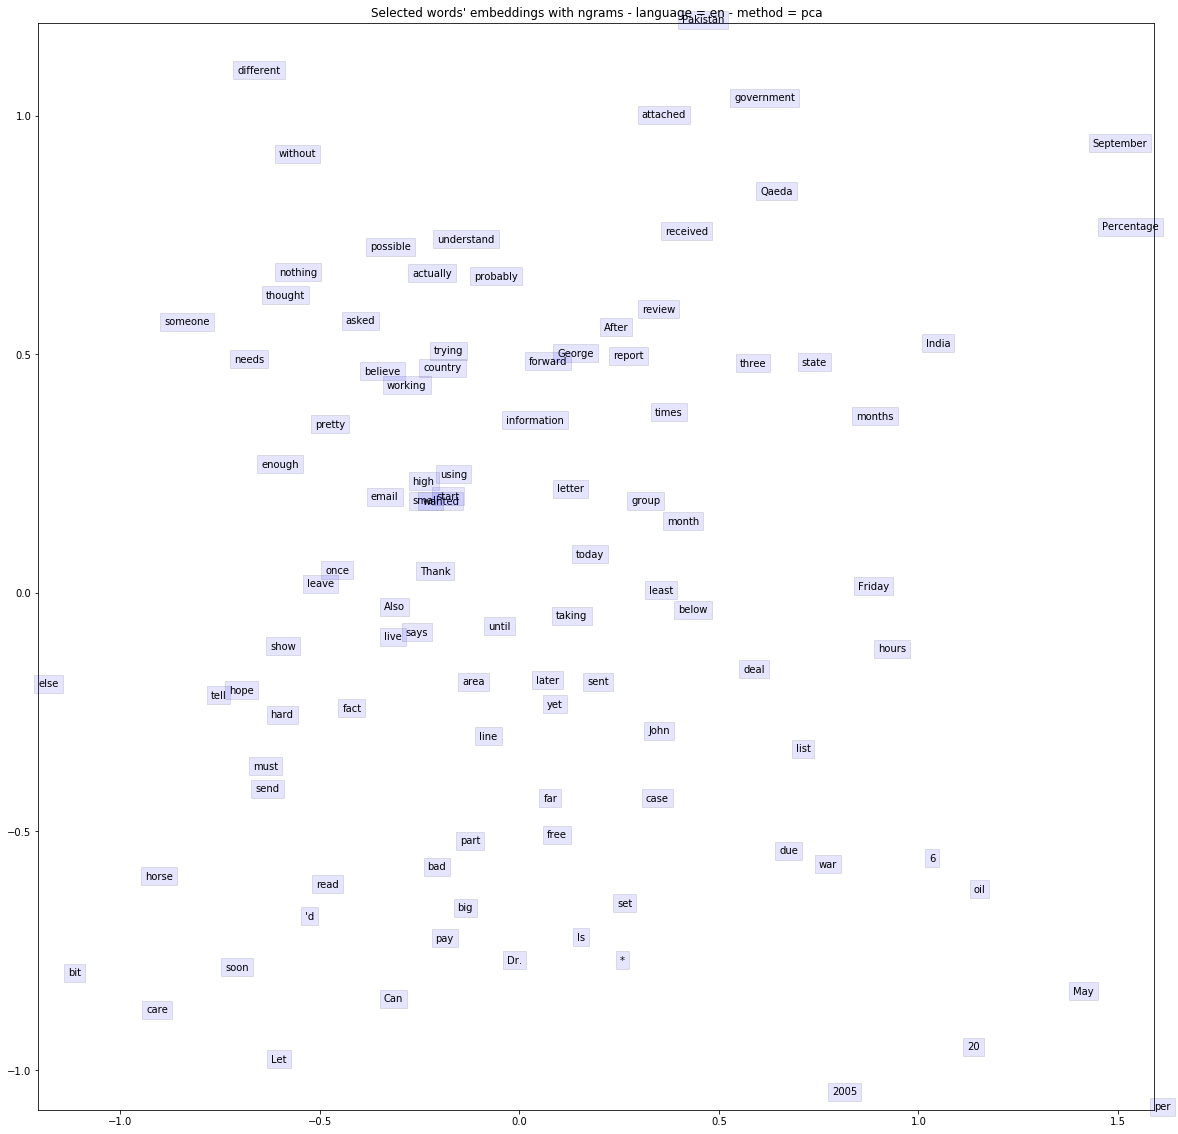

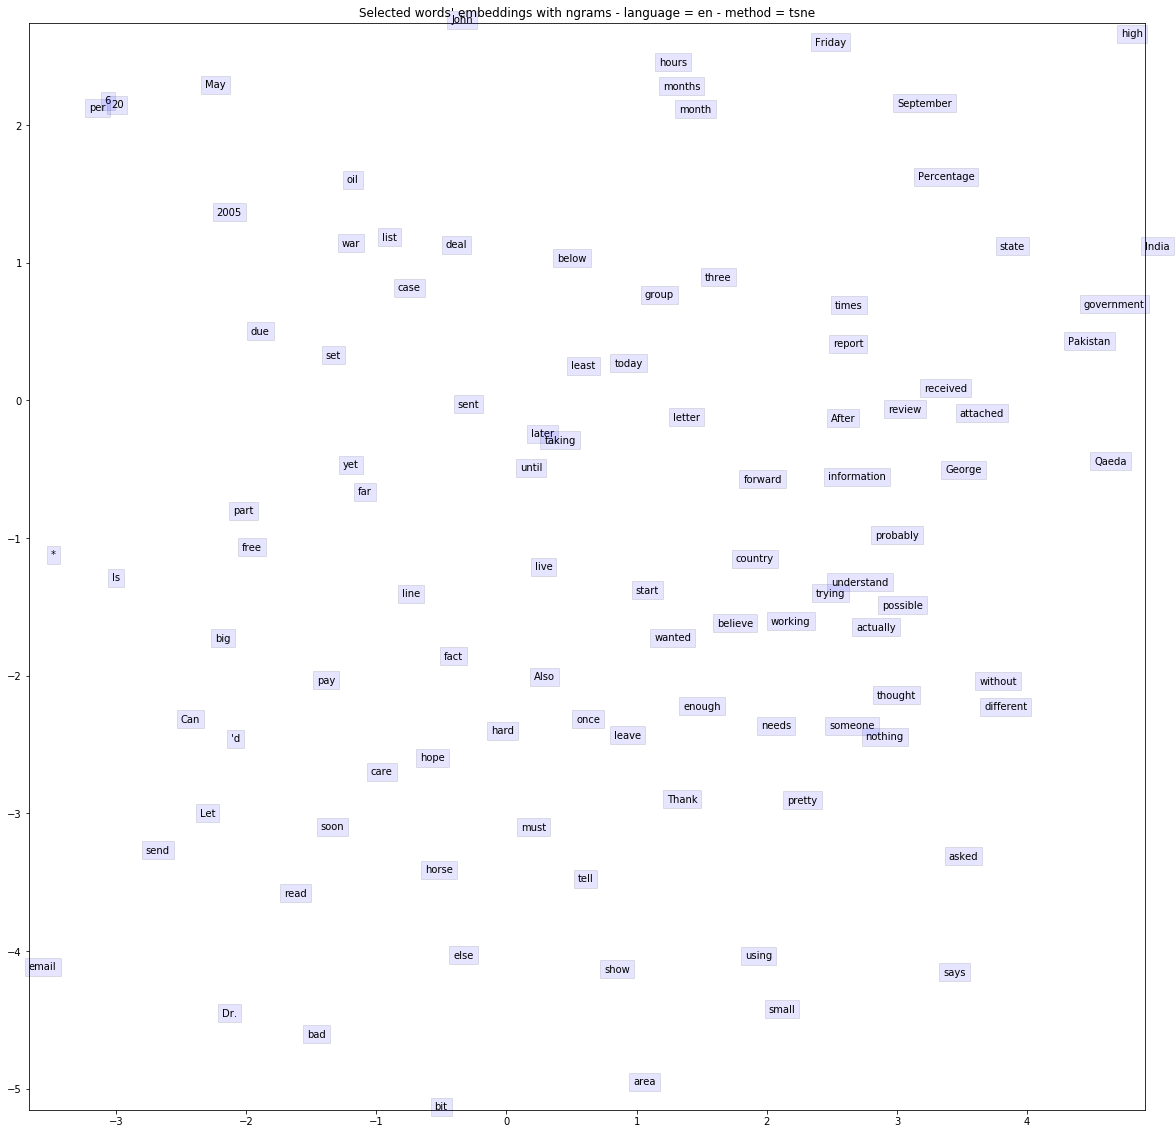

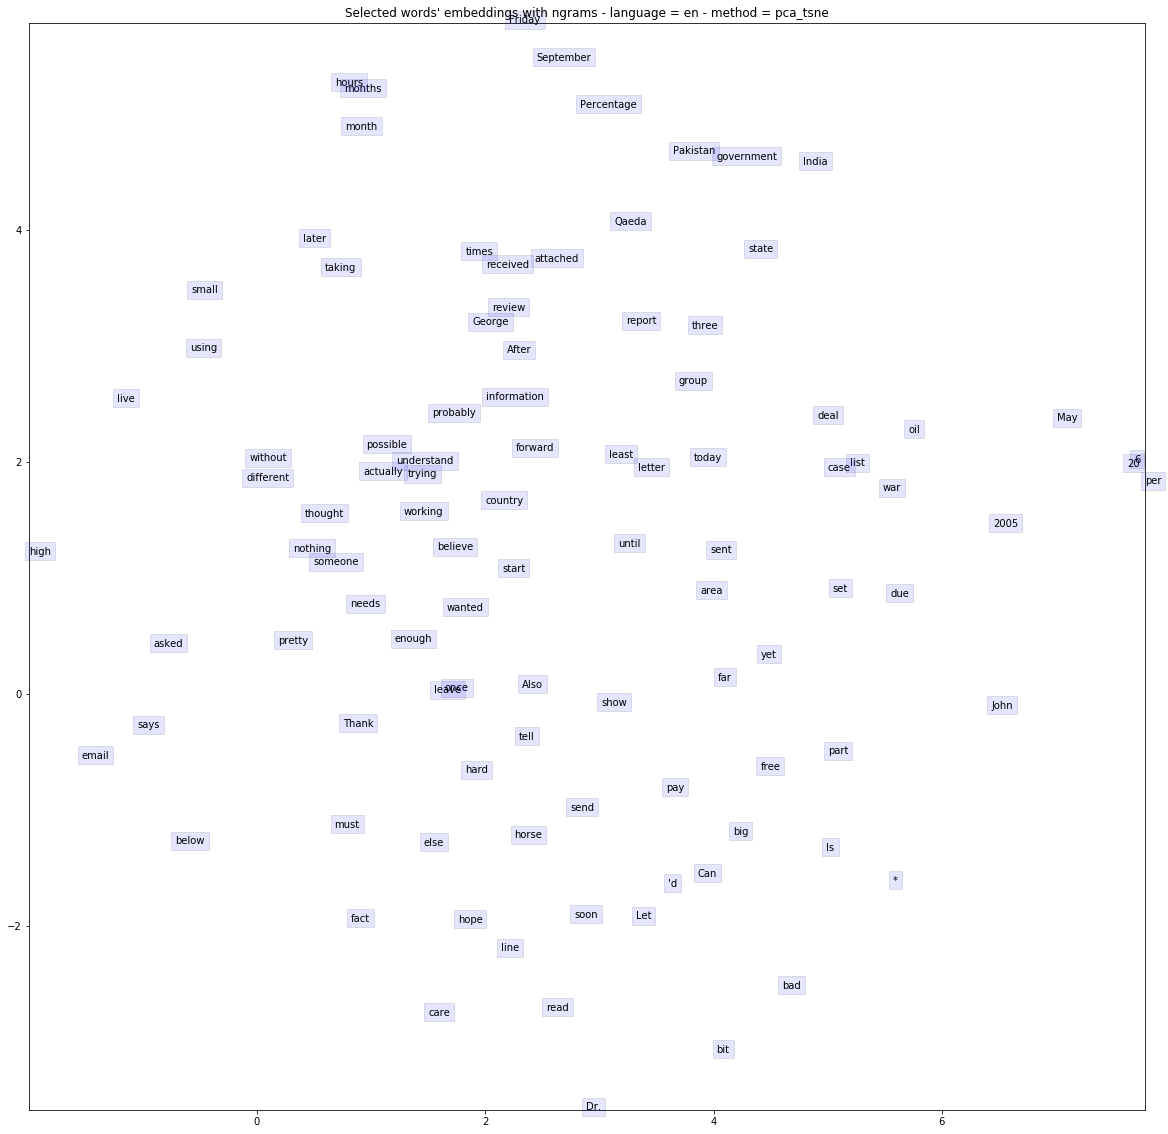

In [7]:
list_of_idx = list(range(300,400))
VisualizeChosenWords(data_dir, save_dir, lan, list_of_idx, ngrams = False,
                     pca=True, tsne=True, both=True)
VisualizeChosenWords(data_dir, save_dir, lan, list_of_idx, ngrams = True,
                     pca=True, tsne=True, both=True)